In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import peakutils
import datetime
import warnings
from jupyterthemes import jtplot

import logging

In [14]:
logging.getLogger().setLevel(logging.CRITICAL)

from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *

In [3]:
jtplot.style('default', grid=False)
plt.rcParams['errorbar.capsize'] = 8
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 2.5
plt.rc('font', size= 18)
plt.rc('legend', fontsize= 15)
plt.rc('xtick', labelsize= 18)
plt.rc('ytick', labelsize= 18)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)

In [5]:
asf = dict({'C_1s' : 0.296, 'O_1s' : 0.711, 'N_1s' : 0.477, 'Ba_3d' : 7.49,
            'Cu_2p' : 5.321, 'Cl_2p' : 0.891})

# Analysis experiments on Cu from 19.10.2020

## Read processed experiments

In [76]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/**/*.xy'

files = glob.glob(path, recursive=True)
files.sort()
files_new = []

for f in files:
    if ('/proc' in f):
        files_new.append(f)
files = files_new

files.pop(4)
files[3], files[4] = files[4], files[3]
files

['/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/2020_09_11_Cu/proc/20200911_Cu_clean3.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/2020_09_11_Cu/proc/20200915_Cu_metOH_400pulses.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/2020_09_11_Cu/proc/20200916_Cu_FBI_metOH_400pulses.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/2020_09_11_Cu/proc/20200917_Cu_FBI_metOH_400pulses_annealing.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_metOH/2020_09_11_Cu/proc/20200917_Cu_FBI_metOH_400pulses_BaCl_subl_30min.xy']

In [80]:
proc_exps = [read_processed_xp(f) for f in files]
for xp in proc_exps[2:]:
    xp.name = xp.name.replace('_metOH', '')

## Show individual plots

In [11]:
proc_exps[0].dfx.columns

MultiIndex(levels=[['Ba_3d', 'C_1s', 'Cl_2p', 'Cu_2p', 'N_1s', 'O_1s', 'overview_'], ['counts', 'energy']],
           labels=[[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6], [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]],
           names=['range', 'properties'])

In [12]:
regions = proc_exps[0].dfx.columns.levels[0].values
regions= ['N_1s', 'C_1s', 'O_1s', 'Ba_3d', 'Cl_2p', 'Cu_2p']

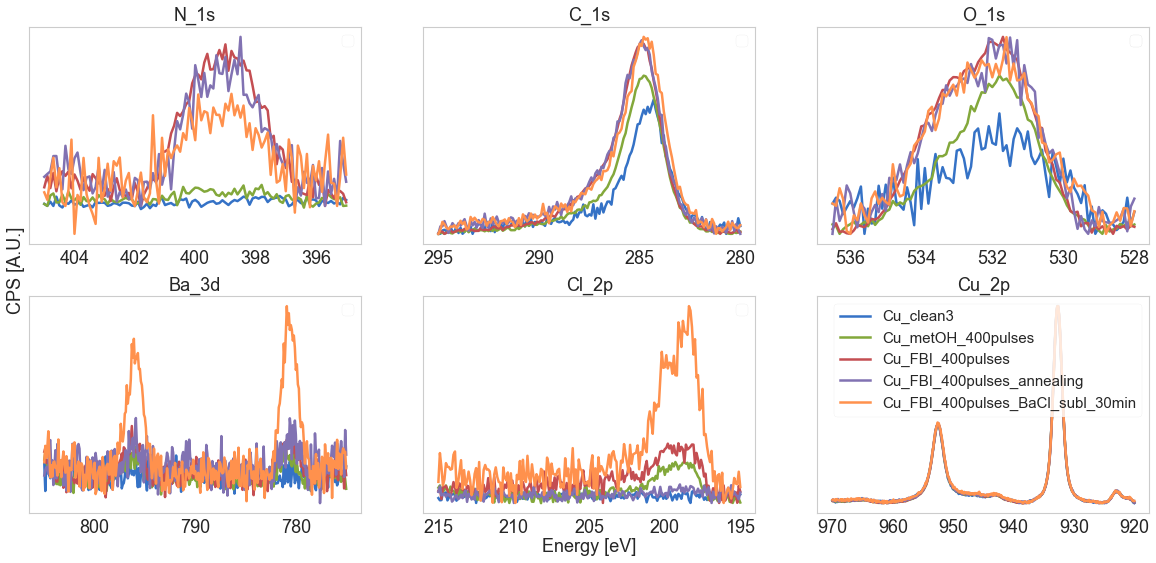

In [83]:
ax = plot_xp_regions(proc_exps, regions, ncols=3);
plt.gcf().savefig('/Users/pabloherrero/Dropbox/phd/papers/fbi_cu_sublimation/FBI_metOH_ALI.png', dpi=200)

### Normalized spectra

In [19]:
def plot_normal_regions(experiments : list, regions : list, colors : list = [], ncols: int = 3):
    """Subplots all regions of a list of experiments (unnormalised)"""
    rows = int(np.ceil(len(regions) / ncols))

    fig, ax = plt.subplots(rows, ncols, figsize=(16, 8))
    fig.add_subplot(111, frameon=False, xticks=[], yticks=[])  # Used for common xlabel and ylabel

    for i,r in enumerate(regions):
        for c,xp in enumerate(experiments):
            xp_norm = normalise_dfx(xp, inplace=False)
            j, k = i//ncols, i%ncols

            if i == len(regions) - 1:   # Set labels from last region
                lb = xp.name

            else:
                lb='__nolabel__'

            try:
                li = plot_region(xp_norm, r, ax=ax[j][k], lb=lb)
                ax[j][k].legend()
                ax[j][k].invert_xaxis()
            except KeyError:    # Auto-exclude regions not recorded for a particular experiment
                pass

            ax[j][k].set_title(r)
            ax[j][k].set_yticks([])
#
        if len(experiments)%2 == 0:
            ax[j][k].invert_xaxis()
    plt.xlabel('\nEnergy [eV]', ha='center')
    plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
    return ax

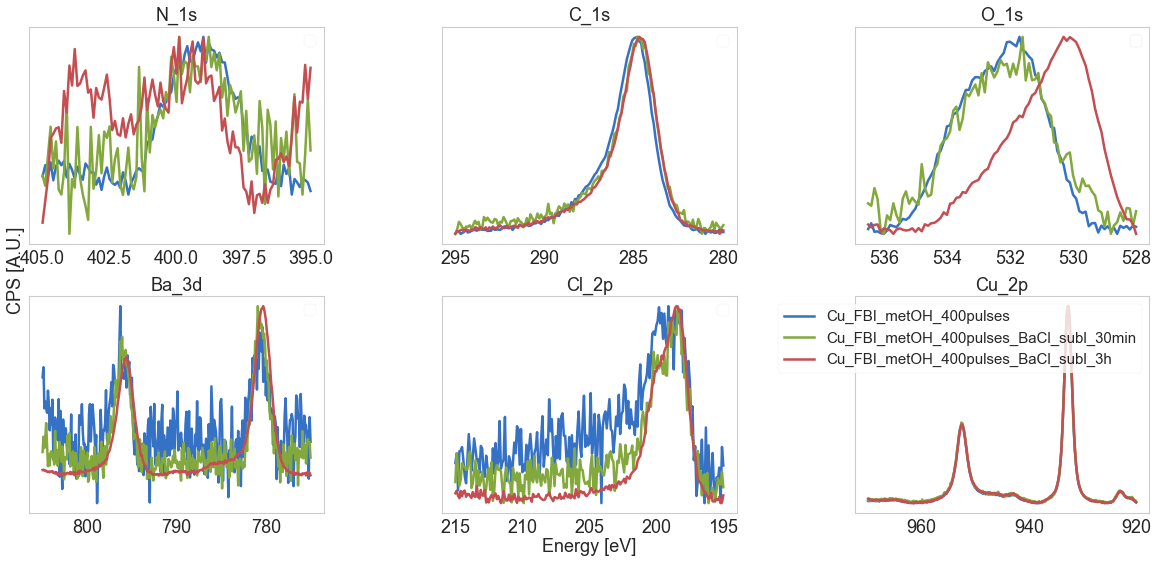

In [22]:
plot_normal_regions(proc_exps[2:5], regions);

## Integrate areas 

### C 1s

/Users/pabloherrero/sabat/sabatsw/xps/xps_analysis.py:66: RuntimeWarning: invalid value encountered in greater
  


[4361.5042350648555,
 4954.542692592035,
 6370.346950807191,
 6911.655218674652,
 7035.708603219859]

<Figure size 460.8x403.2 with 0 Axes>

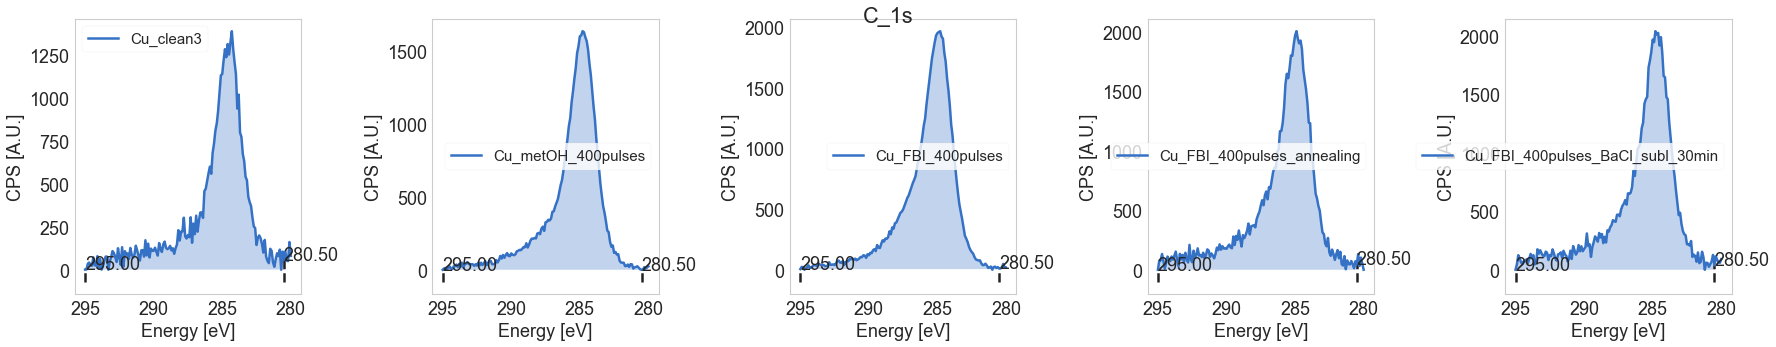

In [86]:
region = 'C_1s'
integrateRegions(proc_exps, region, indRef=1, asf=asf)

#### Correct for bg substrate abundance

In [87]:
for xp in proc_exps[1:]:
    uncorr_area = xp.area['C_1s']
    xp.area.update({'C_1s': uncorr_area - proc_exps[0].area['C_1s']})

### O 1s

[1292.7479538673213,
 1515.801154548271,
 2094.037759446386,
 2123.468403395831,
 2136.5523176387146]

<Figure size 460.8x403.2 with 0 Axes>

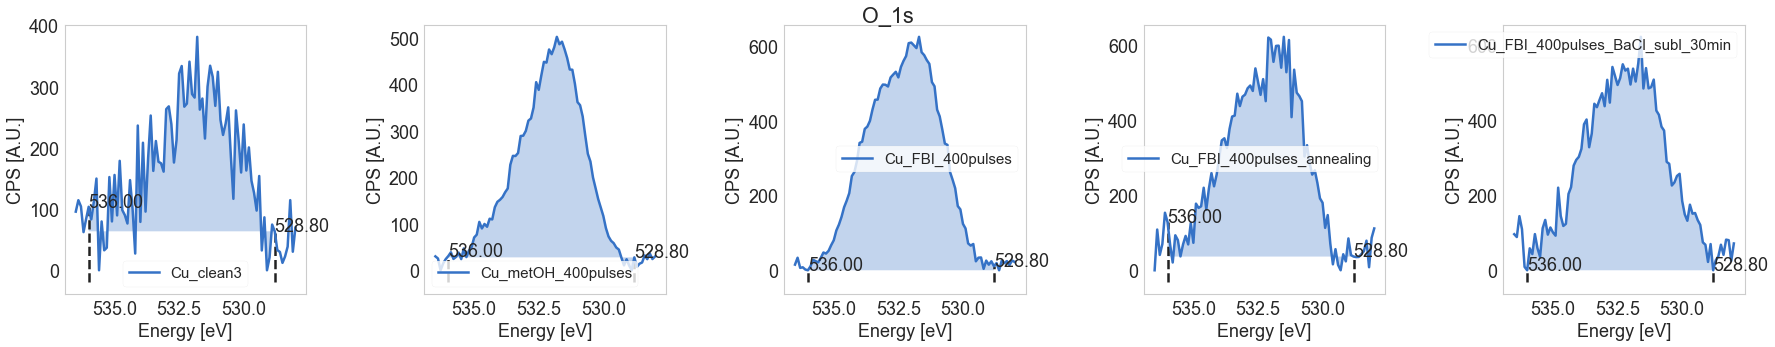

In [88]:
region = 'O_1s'
integrateRegions(proc_exps, region, indRef=4, asf=asf)

#### Correct for bg substrate abundance

In [89]:
for xp in proc_exps[1:]:
    uncorr_area = xp.area['O_1s']
    xp.area.update({'O_1s': uncorr_area - proc_exps[0].area['O_1s']})

### N 1s

[19.901438984074517,
 52.86396288573303,
 438.8241278334734,
 392.3108488384223,
 299.9031165902863]

<Figure size 460.8x403.2 with 0 Axes>

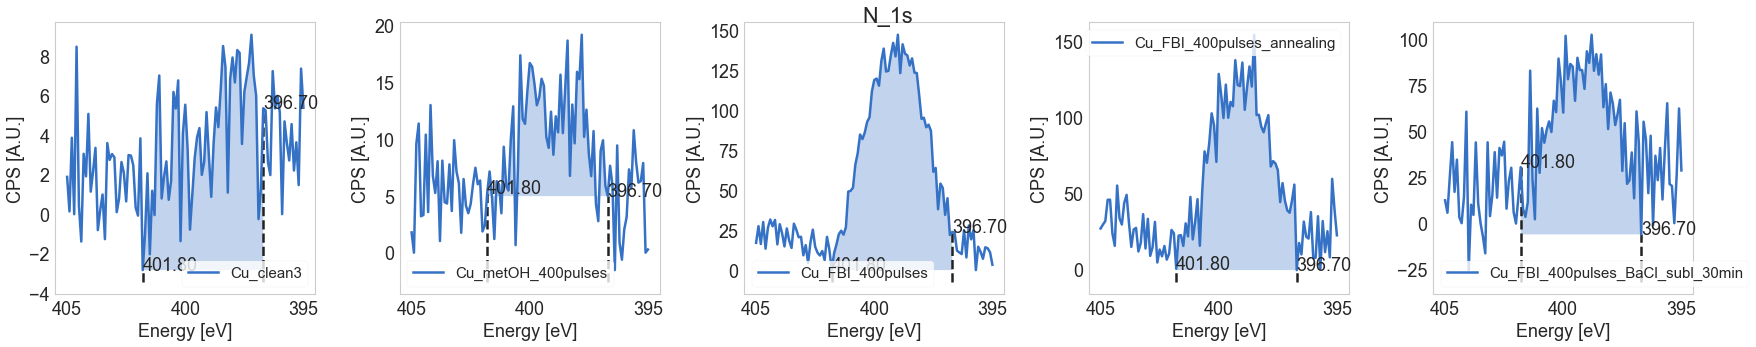

In [91]:
region = 'N_1s'
integrateRegions(proc_exps, region, indRef=3, asf=asf)

### Ba 3d

In [92]:
def integrateRegions(exps: list, region : str, indRef: int, asf: dict, 
                     eup: float = None, edw: float = None,
                     lb : str = None, flag_fill : bool = True):
    """Integrate peaks for a list of experiments between two minima
       The minima are automatically located for exps[indRef] unless they are specified by eup and edw
    The boundary are fixed for the whole list."""

    xRef = exps[indRef].dfx[region].dropna().energy     # Use the energy array of reference xp to crop the other xp's

    if eup == None or edw == None:
        ind = flexible_integration_limits(exps[indRef], region=region, doublePeak=0, flag_plot=False)
        lmidx, rmidx = ind[-2:] # The index of the minima are always the last two
        eup, edw = xRef[lmidx], xRef[rmidx]
        plt.clf()

    fig, ax = plt.subplots(1, len(exps), figsize=(len(exps)*5, 5) )
    area = []
    for i, xp in enumerate(exps):
        try:
            y = xp.dfx[region].dropna().counts
        except KeyError as e:          #Check the region exists in this xp
            print(e, 'region does not exist in ' + xp.name)
            xp.area.update({region: 0})
            continue

        x = xp.dfx[region].dropna().energy
        ax[i].plot(x, y, label=xp.name)

        xpCrop = crop_spectrum(xp, region, eup = eup, edw = edw)
        yc = xpCrop.dfx[region].dropna().counts.values
        xc = xpCrop.dfx[region].dropna().energy.values    # Integrate only in the cropped range

        step = x[0] - x[1]
        area.append(np.trapz(yc, dx=step))

        try:
            xp.area.update({region : area[-1]/asf[region]})
        except (KeyError, NameError) as e:
            print(e, ', asf missing, returning raw area')
            pass

        if flag_fill:
            if yc[0] > yc[-1]:
                ax[i].fill_between(xc , y1 = yc[-1], y2 = yc, alpha=0.3)
            else:
                ax[i].fill_between(xc, y1 = yc[0], y2 = yc, alpha=0.3)
            ybase = ax[i].get_ylim()[0]

            for j in [0, -1]:
                ax[i].vlines(xc[j], ymin=ybase, ymax=yc[j], linestyles='--')
                ax[i].text(s='%.2f'%xc[j], x = xc[j], y = yc[j])
        cosmetics_plot(ax=ax[i])
    plt.tight_layout()
    fig.suptitle(region)
    return area

[2066.3243903656075,
 2082.7088552871573,
 3147.1164551285947,
 4138.490506104832,
 6300.1069817061125]

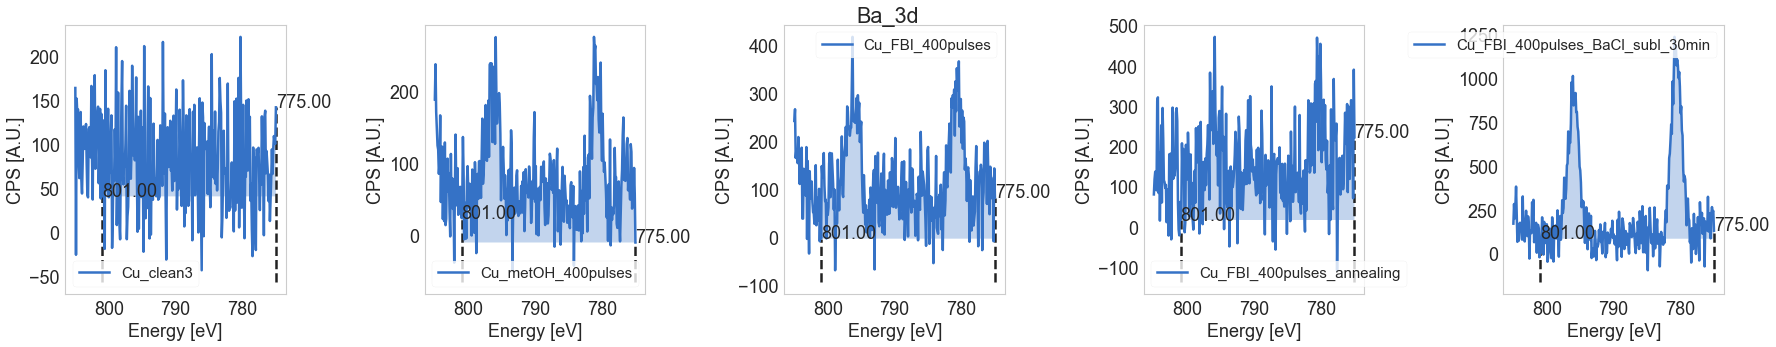

In [95]:
region = 'Ba_3d'
integrateRegions(proc_exps, region, indRef=3, eup=801, edw=775, asf=asf)

In [46]:
rmidx

295

### Cl 2p

[327.0341660783498,
 699.5160270945403,
 1250.620538759562,
 412.3083652910963,
 2766.052035018931]

<Figure size 460.8x403.2 with 0 Axes>

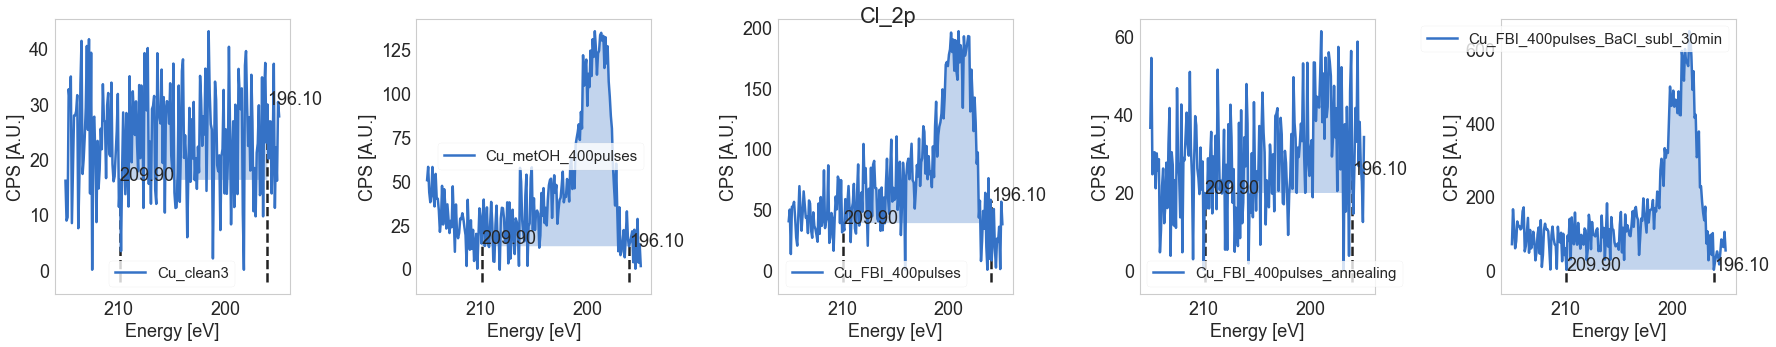

In [96]:
region = 'Cl_2p'
integrateRegions(proc_exps, region, indRef=4, asf=asf)

### Cu 2p

[421858.1627460294,
 416388.17514689546,
 419561.9687552848,
 426832.7723656225,
 435972.58589969325]

<Figure size 460.8x403.2 with 0 Axes>

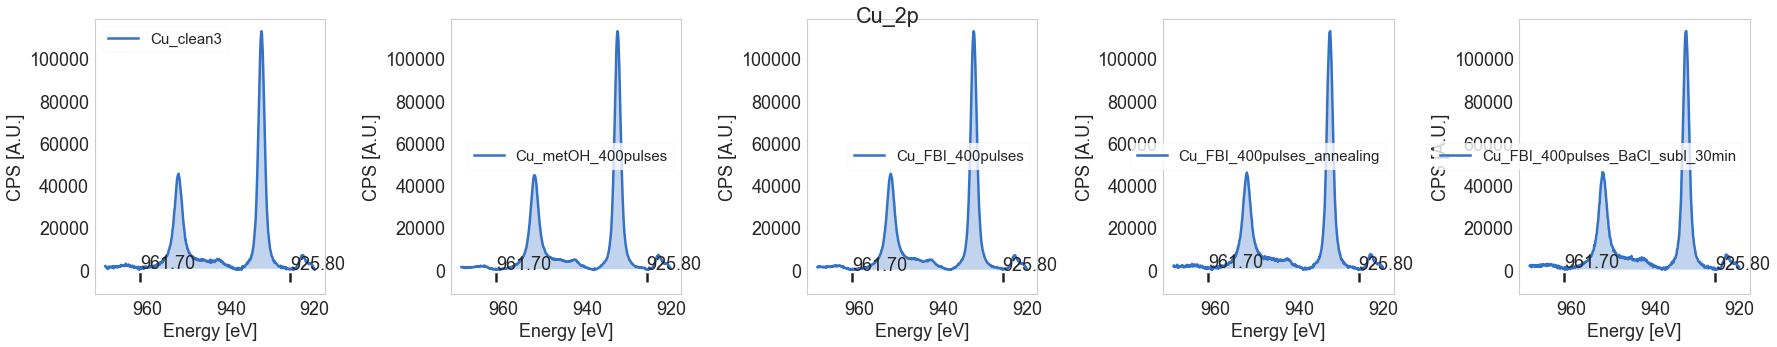

In [97]:
region = 'Cu_2p'
integrateRegions(proc_exps, region, indRef=2, asf=asf)

## Stoichiometry 

In [102]:
def make_stoichometry_table(exps : list, num : list, denom : list, sep='\t'):
    """Print stoichiometry table of the experiments exps at the regions in num/denom
    Example: make_stoichometry_table(oxid_exps, 'N1s', 'C1s'], ['Br3p', 'O1s'])
    will print the stoichiometry N/C, Br/O for the passed experiments"""

    make_header(num = num, denom = denom)
#     print('Experiment, ' + )
    for k, xp in enumerate(exps):
        row = xp.name + sep
        for i, j in zip (num, denom):
            row += ('%.2f %s ' %(xp.area[i]/xp.area[j], sep))
        print(row )

In [99]:
num, denom = (('N_1s', 'C_1s', 'C_1s', 'Ba_3d'), ('O_1s', 'N_1s', 'O_1s', 'N_1s'))
make_stoichometry_table(proc_exps,  num=num, denom=denom)
print('Nominal \t', 3/5, '\t', '%.3f'%(31/3), '\t', '%.3f' %(31/5), '\t %.3f' %(1/3) )

Experiment	N_/O_	C_/N_	C_/O_	Ba_/N_	
Cu_clean3	0.02	 353.17	 8.10	 6.61	 
Cu_metOH_400pulses	0.35	 18.08	 6.39	 2.51	 
Cu_FBI_400pulses	0.82	 7.38	 6.02	 0.46	 
Cu_FBI_400pulses_annealing	0.70	 10.48	 7.37	 0.67	 
Cu_FBI_400pulses_BaCl_subl_30min	0.53	 14.37	 7.61	 1.34	 
Nominal 	 0.6 	 10.333 	 6.200 	 0.333


In [106]:
num, denom = (('N_1s', 'C_1s', 'C_1s', 'Ba_3d'), ('O_1s', 'N_1s', 'O_1s', 'N_1s'))
make_stoichometry_table(proc_exps,  num=num, denom=denom, sep=' & ')
print('Nominal  & ', 3/5, ' & ', '%.3f'%(31/3), ' & ', '%.3f' %(31/5), ' &  %.3f' %(1/3) )

Experiment	N_/O_	C_/N_	C_/O_	Ba_/N_	
Cu_clean3 & 0.02  &  353.17  &  8.10  &  6.61  &  
Cu_metOH_400pulses & 0.35  &  18.08  &  6.39  &  2.51  &  
Cu_FBI_400pulses & 0.82  &  7.38  &  6.02  &  0.46  &  
Cu_FBI_400pulses_annealing & 0.70  &  10.48  &  7.37  &  0.67  &  
Cu_FBI_400pulses_BaCl_subl_30min & 0.53  &  14.37  &  7.61  &  1.34  &  
Nominal  &  0.6  &  10.333  &  6.200  &  0.333


In [55]:
print('Nominal')
print('N/O \t C/N \t \t C/O \t Ba/N (1eq.)')
print(3/5, '\t', '%.3f'%(31/3), '\t', '%.3f' %(31/5), '\t %.3f' %(1/3) )

Nominal
N/O 	 C/N 	 	 C/O 	 Ba/N (1eq.)
0.6 	 10.333 	 6.200 	 0.333
